In [59]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets

from dbc import *

In [60]:
X_train, y_train = datasets.make_blobs(n_samples=[125 * 5, 125 * 2], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                                           cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True, random_state=42)

In [61]:
DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=10,random_state=25)
DBC_kmeans.fit(X_train,y_train)
y_pred = DBC_kmeans.predict(X_train)
compute_conditional_risk(y_train, y_pred)

(array([0.1024, 0.444 ]),
 array([[0.8976, 0.1024],
        [0.444 , 0.556 ]]))

In [62]:
DBC_kmeans.predict_prob(X_train)

array([[0.56603774, 0.43396226],
       [1.        , 0.        ],
       [0.56603774, 0.43396226],
       ...,
       [0.61971831, 0.38028169],
       [1.        , 0.        ],
       [0.56603774, 0.43396226]])

In [63]:
DBC_fcm = CmeansDiscreteBayesianClassifier(n_clusters=10, fuzzifier=1.5, cluster_centers=DBC_kmeans.cluster_centers)
DBC_fcm.fit(X_train,y_train)
y_pred = DBC_fcm.predict(X_train)
compute_conditional_risk(y_train, y_pred)

(array([0.0976, 0.448 ]),
 array([[0.9024, 0.0976],
        [0.448 , 0.552 ]]))

In [64]:
DBC_fcm.predict_prob(X_train)

array([[0.58921146, 0.41078854],
       [0.96032963, 0.03967037],
       [0.57972101, 0.42027899],
       ...,
       [0.63172343, 0.36827657],
       [0.99650729, 0.00349271],
       [0.47769661, 0.52230339]])

Text(0.5, 1.0, 'PDBC with soft clustering')

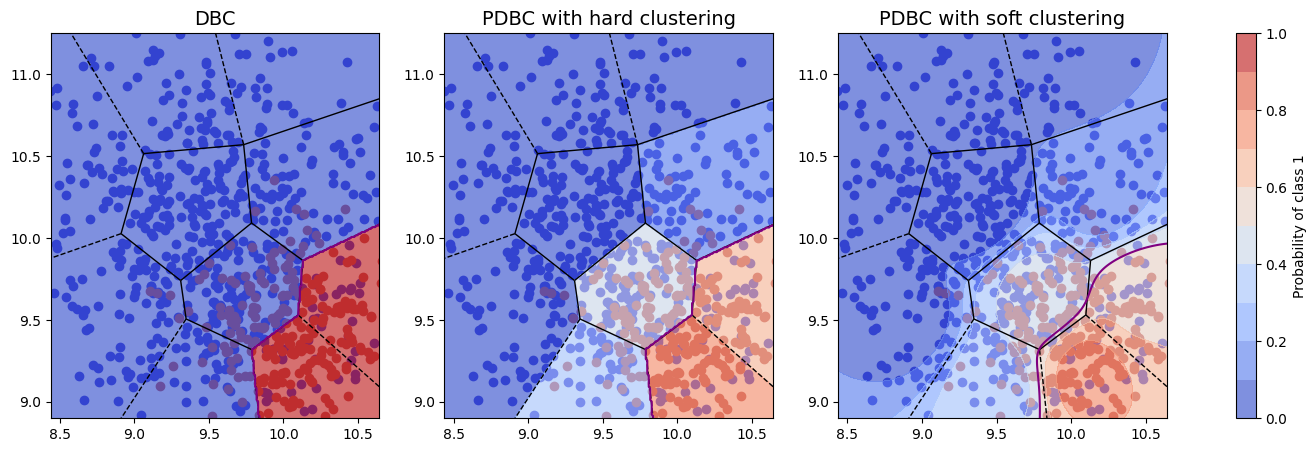

In [65]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DBC_kmeans.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[2])

Z1 = DBC_kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z0 = np.zeros_like(Z1)

max_indices = np.argmax(Z1, axis=1)

rows = np.arange(Z1.shape[0])

Z0[rows, max_indices] = 1.0

Z1 = Z1[:, 1].reshape(xx.shape)
Z0 = Z0[:, 1].reshape(xx.shape)

Z2 = DBC_fcm.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2[:, 1].reshape(xx.shape)


class0_indices = (y_train == 0)
class1_indices = (y_train == 1)
for i in range(3):
    ax[i].scatter(X_train[class0_indices, 0], X_train[class0_indices, 1], color='mediumblue')
    ax[i].scatter(X_train[class1_indices, 0], X_train[class1_indices, 1], color='firebrick')

contour0 = ax[0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[2].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5


boundary0 = ax[0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[2].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')

ax[0].set_title('DBC', fontsize=14)
ax[1].set_title('PDBC with hard clustering', fontsize=14)
ax[2].set_title('PDBC with soft clustering', fontsize=14)

In [66]:
DMC_kmeans = KmeansDiscreteMinimaxClassifier(n_clusters=10 ,random_state=25)
DMC_kmeans.fit(X_train,y_train)
y_pred = DMC_kmeans.predict(X_train)
compute_conditional_risk(y_train, y_pred)

(array([0.2464, 0.168 ]),
 array([[0.7536, 0.2464],
        [0.168 , 0.832 ]]))

Text(0.5, 1.0, 'PDBC with soft clustering')

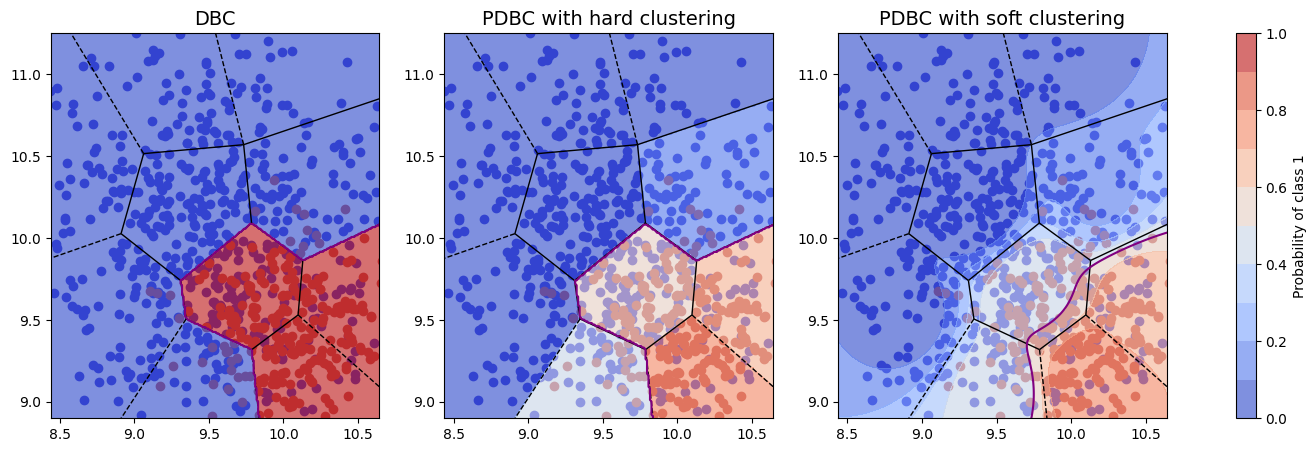

In [67]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DMC_kmeans.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[2])

Z1 = DMC_kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z0 = np.zeros_like(Z1)

max_indices = np.argmax(Z1, axis=1)

rows = np.arange(Z1.shape[0])

Z0[rows, max_indices] = 1.0

Z1 = Z1[:, 1].reshape(xx.shape)
Z0 = Z0[:, 1].reshape(xx.shape)

Z2 = DBC_fcm.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=DMC_kmeans.prior_star)
Z2 = Z2[:, 1].reshape(xx.shape)


class0_indices = (y_train == 0)
class1_indices = (y_train == 1)
for i in range(3):
    ax[i].scatter(X_train[class0_indices, 0], X_train[class0_indices, 1], color='mediumblue')
    ax[i].scatter(X_train[class1_indices, 0], X_train[class1_indices, 1], color='firebrick')

contour0 = ax[0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[2].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5


boundary0 = ax[0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[2].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')

ax[0].set_title('DBC', fontsize=14)
ax[1].set_title('PDBC with hard clustering', fontsize=14)
ax[2].set_title('PDBC with soft clustering', fontsize=14)